# ** Plotting the 100 replicates for 1Mbp string 10x coverage genome vs sim  triplet frequency with bootstrapping for variance** 
- here: 5 replicates of 1Mpb each 

In [3]:
import json
from tqdm import tqdm 
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np

**declaring basic objects ** 

In [17]:
model = json.load(open("../Human_mutability_model/Model_2020_12_02_genomeWide.txt"))

In [18]:
triplets = []
for b1 in ["A", 'T', 'C', 'G']: 
    for b2 in ["A", 'T', 'C', 'G']: 
        for b3 in ["A", 'T', 'C', 'G']: 
            triplets.append(b1+b2+b3)

In [19]:
muts = []
for triplet in triplets: 
    muts.append(model[triplet][0])

** reading in the simulation DNAF into dictionary ** 

In [4]:
ntrials = 101

In [5]:
DNAF_dataDict = {}
for i in range(1, ntrials+1): 
    trial_name = "Trial"+str(i)
    DNAF_dataDict[trial_name] = open("data/{t}_DNA.txt".format(t=trial_name)).readlines()[0]

** setting the length of dna vs replicate # ** 

In [40]:
n_replicates = 5
dna_length = int(len(DNAF_dataDict["Trial1"])*(ntrials-1)/n_replicates)
trial_bounds = [((ntrials-1)/n_replicates)*i+1 for i in range(1,n_replicates+1)]
print(trial_bounds)

[21.0, 41.0, 61.0, 81.0, 101.0]


** creating the (nomralized) dictionary of dicvtionary triplet counts (one triplet count dict per replicate) ** 

In [54]:
triplet_dictdict_counts = {}
trial_start = 0
for trial_bound in tqdm(trial_bounds): 
    #make the dict triplet with 0 values attached 
    bound_name = str(int(trial_start+1))+"-"+str(int(trial_bound))
    triplet_dictdict_counts[bound_name] = {}
    for triplet in triplets: 
        triplet_dictdict_counts[bound_name][triplet] = 0
    
    #filling those dictionaries with the triplet counts 
    for trial_number in range(int(trial_start+1), int(trial_bound+1)): #trial start need to be plus one so the next one afterts right AFTER the previous end 
        trial_name = "Trial"+str(trial_number)
        dna = DNAF_dataDict[trial_name]
        for i in range(1, len(dna)-1): 
            triplet = dna[i-1:i+2]
            triplet_dictdict_counts[bound_name][triplet] += 1
    
    #normalizing the counts (frequency) 
    for triplet_key, count in triplet_dictdict_counts[bound_name].items(): 
        triplet_dictdict_counts[bound_name][triplet_key] = count/dna_length
        
    # makes the next bound start where this one ended     
    trial_start = trial_bound 
    

100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


** getting the list of means and stderr ** 

In [56]:
av_triplet_counts = []
stderr_triplet_counts = []

for triplet in triplets: 
    triplet_list = []
    for tripletcountdict in triplet_dictdict_counts.values(): 
        triplet_list.append(tripletcountdict[triplet])
    av_triplet_counts.append(np.mean(triplet_list))
    stderr_triplet_counts.append(np.std(triplet_list)/np.sqrt(n_replicates)) 

** getting and normalizing the genome triplet counts ** 

In [60]:
triplet_genome_counts_dict = json.load(open("../HumanTripletCounts/GenomeTripletCounts_2020_12_02_genomeWide.txt"))

In [61]:
triplet_genome_counts_list = []
for triplet in triplets: 
    triplet_genome_counts_list.append(int(triplet_genome_counts_dict[triplet]))

In [62]:
sum_trips_genome = sum(triplet_genome_counts_list)

In [63]:
for index, element in enumerate(triplet_genome_counts_list): 
    triplet_genome_counts_list[index] = element/ sum_trips_genome

** plotting both together with mutability coloration** 

In [64]:
plt.style.use("seaborn-ticks")

In [69]:
edge_colors = []
for mut in muts: 
    if mut <= 0.00020: 
        edge_colors.append("grey")
    elif mut <= 0.0003: 
        edge_colors.append("dimgrey")
    else: 
        edge_colors.append("black")
        

In [68]:
prop_muts = 10

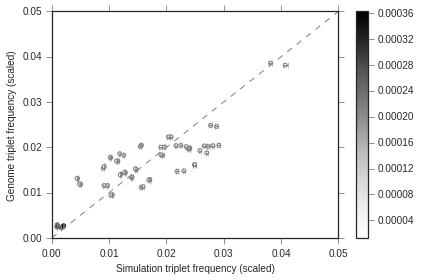

In [77]:
plt.scatter(av_triplet_counts,triplet_genome_counts_list, s = 15, color = muts,  edgecolor = edge_colors, cmap = "Greys")
plt.plot([0,0.055], [0,0.055], color = "grey", linestyle='dashed')
plt.xlabel("Simulation triplet frequency (scaled)")
plt.ylabel("Genome triplet frequency (scaled)")
sim_details = "1MBp_10xMuts_accurateIntoTrip"

plt.colorbar()

plt.xlim((0,0.05))
plt.ylim((0,0.05))
plt.xticks([0,0.01,0.02,0.03,0.04, 0.05])
plt.yticks([0,0.01,0.02,0.03,0.04, 0.05])

plt.errorbar(av_triplet_counts, triplet_genome_counts_list, xerr = np.array(stderr_triplet_counts), ecolor = "grey", ls = "None")

# plt.show()
timestamp = datetime.now().strftime("%Y/%m/%d_%H:%M:%S").replace("/", "_").replace(":", "_")
plt.tight_layout()
plt.savefig("plots/Scatter_{t}_{l}Mbp_{p}propmuts_accurateINTO_genomeVsim_stderr_{r}reps.png".format(p = prop_muts, l = str(dna_length/1000000), t = timestamp, r = n_replicates))